# Clustering illustrations

In [1]:
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import codpy.core as core
from codpy.clustering import *
from codpy.kernel import Kernel
from codpy.plot_utils import multi_plot
from sklearn.metrics.pairwise import pairwise_distances

In [2]:

def gen_blobs(Nx, Ny, D):
    """
    Generate blob data for clustering.

    Parameters:
    - Nx: Number of samples for training.
    - Nz: Number of samples for testing.
    - Ny: Number of centers (clusters).
    - D: Number of dimensions (features).

    Returns:
    - X: Generated data points.
    - y: Cluster labels for each point.
    """
    X, y = make_blobs(
        n_samples=Nx,
        n_features=int(D),
        centers=int(Ny),
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=True,
        random_state=1,
    )
    return X, y

In [3]:
def greedy_clustering(x, Ny):
    """
    Apply a fast greedy search algorithms for clustering.

    Parameters:
    - x: Training data.
    - Ny: Number of clusters.

    Returns:
    - fx: Predicted cluster labels for test data.
    - centers: Selected cluster centers.
    """
    # Set up a kernel and select centers
    kernel = GreedySearch(x=x, N=Ny, set_kernel=set_gaussian_kernel, all=True)
    # retrieve the centers
    centers = kernel.cluster_centers_
    # retrieve labels associated to a set of points
    fx = kernel.get_labels()
    return fx, centers


def sharp_clustering(x, Ny):
    # Set up a kernel and select centers
    kernel = SharpDiscrepancy(x=x, N=Ny, set_kernel=set_gaussian_kernel)
    centers = kernel.cluster_centers_
    labels = kernel.get_labels()
    return labels, centers


def kmeans_clustering(x, Ny):
    kernel = KMeans(n_clusters=Ny, random_state=1).fit(x)
    centers = kernel.cluster_centers_
    labels = kernel.labels_
    return labels, centers


def balanced_greedy_clustering(x, Ny):
    method = GreedySearch(x=x, N=Ny, set_kernel=set_gaussian_kernel, all=True)
    method = BalancedClustering(method)
    centers = method.cluster_centers_
    labels = method.get_labels()
    return labels, centers


class Random_clusters:
    def __init__(self, x, N, **kwargs):
        self.x = x
        self.indices = random.sample(range(self.x.shape[0]), N)
        self.cluster_centers_ = self.x[self.indices]

    def __call__(self, z, **kwargs):
        return self.distance(z, self.cluster_centers_).argmin(axis=1)

    def distance(self, x, y):
        Kernel(x=x, set_kernel=set_gaussian_kernel)
        return core.op.Dnm(x, y)


def balanced_random_clustering(x, Ny):
    method = Random_clusters(x=x, N=Ny)
    method = BalancedClustering(method)
    centers = method.cluster_centers_
    labels = method.get_labels()
    return labels, centers

In [4]:
set_gaussian_kernel = core.kernel_setter(kernel="gaussian", map="standardmean")


def compute_mmd(x_test, z):
    kernel = Kernel(x=x_test, order=0, set_kernel=set_gaussian_kernel)
    mmd = kernel.discrepancy(z)
    return mmd


def compute_inertia(x, y):
    return np.sum((pairwise_distances(x, y) ** 2).min(axis=1))


def one_experiment(X, Ny, get_predictor):
    def get_score(X, cluster_centers):
        inertia = compute_inertia(X, cluster_centers)
        # Calculate MMD for K-means
        mmd = compute_mmd(X, cluster_centers)
        return inertia, mmd

    elapsed_time = time.time()
    labels, cluster_centers = get_predictor(X, Ny)
    elapsed_time = time.time() - elapsed_time
    inertia, mmd = get_score(X, cluster_centers)
    return inertia, mmd, elapsed_time


def run_experiment(Nx_values, D, Ny_values, get_predictors, labels, file_name=None):
    results = []
    for Nx in Nx_values:
        for Ny in Ny_values:
            X, _ = gen_blobs(Nx, Ny, D)
            for get_predictor, label in zip(get_predictors, labels):
                inertia, mmd, elapsed_time = one_experiment(X, Ny, get_predictor)
                print(
                    "Method:",
                    label,
                    "N_partition:",
                    Ny,
                    " inertia:",
                    inertia,
                    " mmd:",
                    mmd,
                    " time:",
                    elapsed_time,
                )
                results.append(
                    {
                        "Method": label,
                        "Nx": Nx,
                        "Ny": Ny,
                        "Execution Time (s)": elapsed_time,
                        "inertia": inertia,
                        "mmd": mmd,
                    }
                )
    out = pd.DataFrame(results)
    print(out)
    if file_name is not None:
        out.to_csv(file_name, index=False)
    return out


def plot_experiment(Nx_values, D, Ny_values, get_predictors, names):
    """
    Run the clustering experiment with different numbers of clusters (Ny) and visualize the results.

    Parameters:
    - Nx: Number of samples for training.
    - Nz: Number of samples for testing
    - D: Number of dimensions (features).
    - Ny_values: List of cluster counts to experiment with.
    """
    results, legends = [], []

    def one_experiment(X, Ny, get_predictor):
        labels, cluster_centers = get_predictor(X, Ny)
        return labels, cluster_centers

    for Nx in Nx_values:
        for Ny in Ny_values:
            X, _ = gen_blobs(Nx, Ny, D)
            for get_predictor, name in zip(get_predictors, names):
                labels, cluster_centers = one_experiment(X, Ny, get_predictor)
                print("Method:", name, "N_partition:", Ny)
                results.append((X, labels, cluster_centers))
                legends.append(name + f",  {Ny}" + " clusters")

    # Plot the clustering results using multi_plot
    def plot_clusters(data, ax, legend="", **kwargs):
        x, labels, centers = data
        ax.scatter(x[:, 0], x[:, 1], c=labels, cmap="viridis", alpha=0.5)
        if centers is not None:
            ax.scatter(
                centers[:, 0],
                centers[:, 1],
                c="red",
                marker="X",
                s=200,
                label="Centers",
            )
        ax.title.set_text(legend)

    multi_plot(
        results,
        plot_clusters,
        mp_nrows=len(Ny_values),
        mp_ncols=len(get_predictors),
        mp_figsize=(14, 10),
        legends=legends,
    )


In [5]:
get_predictors = [
    lambda X, N: greedy_clustering(X, N),
    lambda X, N: sharp_clustering(X, N),
    lambda X, N: kmeans_clustering(X, N),
    lambda X, N: balanced_random_clustering(X, N),
]
labels = ["greedy", "sharp disc.", "kmeans", "bal. random"]
# Run the experiment
Nxs, D, Nys = [1024], 2, [5]
core.kernel_interface.set_verbose()

run_experiment(Nxs, D, [128], get_predictors, labels, file_name=os.path.join("figs_data", "clustering.csv"))

Method: greedy N_partition: 128  inertia: 1028.1806670214105  mmd: 2.5316890621018828e-05  time: 0.18807435035705566
Method: sharp disc. N_partition: 128  inertia: 940.1027681171406  mmd: 5.36674635043255e-06  time: 1.7371034622192383


c:\Users\Shohruh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Method: kmeans N_partition: 128  inertia: 408.93552888977194  mmd: 0.0007832229673651048  time: 0.49050092697143555
Method: bal. random N_partition: 128  inertia: 1096.5876560721308  mmd: 0.0045556553984001935  time: 0.045140981674194336
        Method    Nx   Ny  Execution Time (s)      inertia       mmd
0       greedy  1024  128            0.188074  1028.180667  0.000025
1  sharp disc.  1024  128            1.737103   940.102768  0.000005
2       kmeans  1024  128            0.490501   408.935529  0.000783
3  bal. random  1024  128            0.045141  1096.587656  0.004556


,Method,Nx,Ny,Execution Time (s),inertia,mmd
0,greedy,1024,128,0.188074,1028.180667,0.000025
1,sharp disc.,1024,128,1.737103,940.102768,0.000005
2,kmeans,1024,128,0.490501,408.935529,0.000783
3,bal. random,1024,128,0.045141,1096.587656,0.004556


Method: greedy N_partition: 5
Method: sharp disc. N_partition: 5
Method: kmeans N_partition: 5
Method: bal. random N_partition: 5


c:\Users\Shohruh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


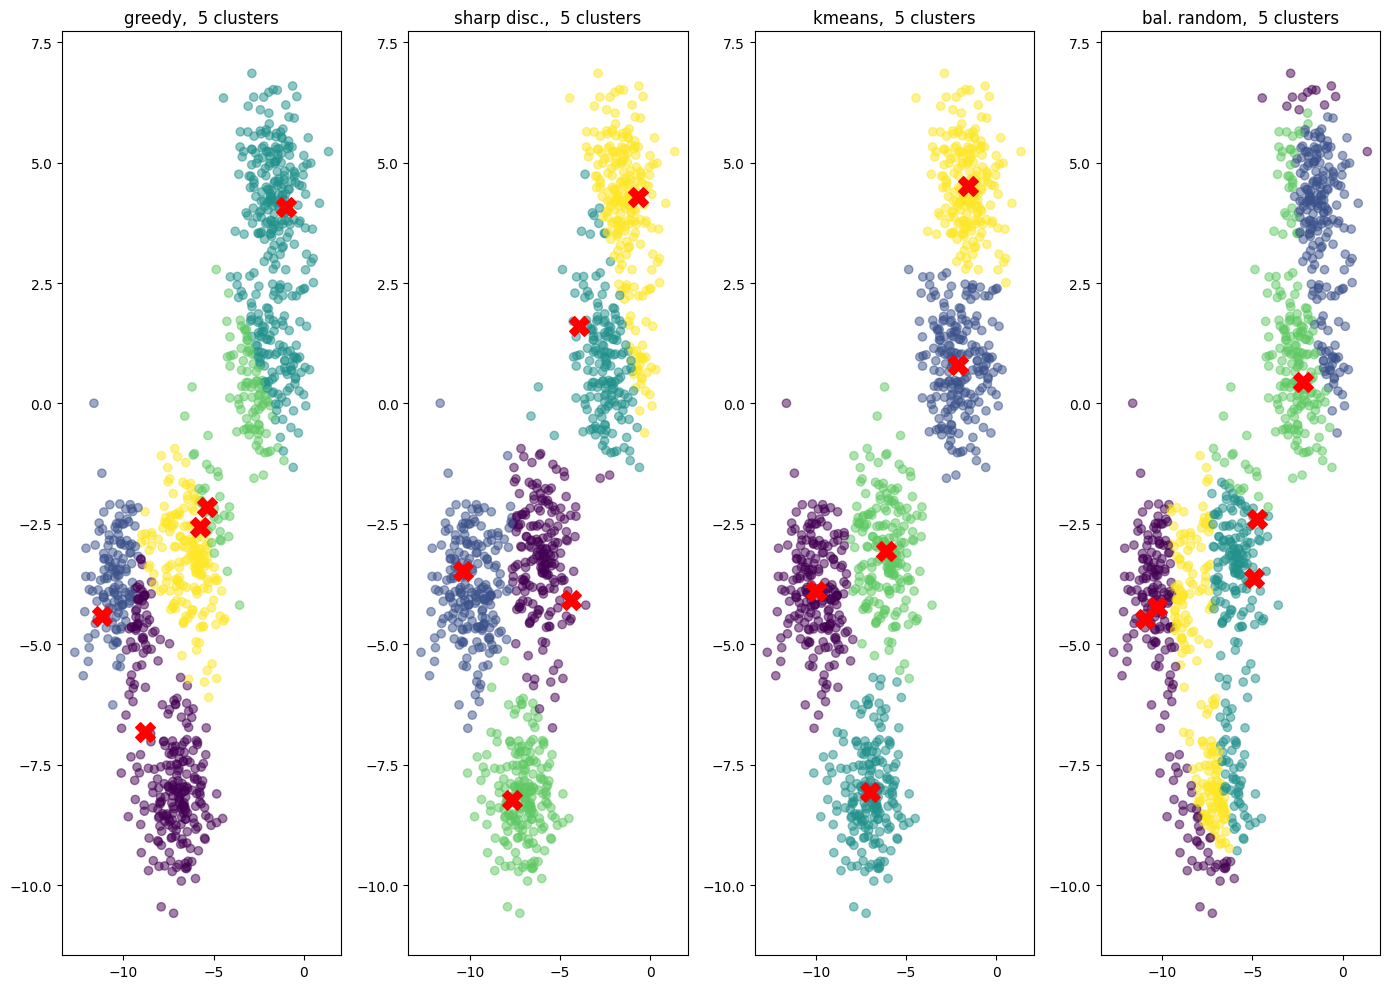

In [6]:
plot_experiment(Nxs, D, Nys, get_predictors, labels)
plt.show()